In [1]:
import torch
import numpy as np
import random
import matplotlib.pyplot as plt
import torch.nn as nn
from torch.nn import functional as F
import pandas as pd

In [2]:
nsamples = 1000
actual_pred = np.random.choice([0, 1], size=(nsamples,), p=[0.2, 0.8])

def calc_acc(pred, true):
    return (np.round(pred) == true).sum()/len(pred)

pred1_acc = 0.8

In [3]:
def generate_pred(nsamples: int = 1000, pred_acc: float = 0.8) -> np.array:
    '''
    This function generates uniform randomly sampled data such that the accuracy is <= pred_acc
    '''
    pred1 = []
    for n in range(nsamples):
        if np.random.rand() < pred_acc:
            if actual_pred[n] == 1:
                pred1.append(random.uniform(0.5, 1))
            else:
                pred1.append(random.uniform(0, 0.5))
        else:
            if actual_pred[n] == 1:
                pred1.append(random.uniform(0, 0.5))
            else:
                pred1.append(random.uniform(0.5, 1))

    return np.array(pred1)

In [4]:
pred1 = generate_pred(1000, 0.8)
# pred1 = torch.tensor(pred1, dtype=torch.float)

# lets do a sanity check
print('pred1 accuracy is ', calc_acc(pred1, actual_pred))

# in an actual ensemble we will have outputs from multiple models.
# these outputs will be mutually correlated.
# to replicate this actual scenario, we want to generate mutually correlated samples
# with similar accuracy levels to the actual model

pred1 accuracy is  0.785


In [5]:
def gen_preds(actual_pred, model_preds, nepochs=100, bce_weight=150,viz=True,max_model_acc=pred1_acc+0.05,max_model_corr=0.95):
    '''
    actual pred - the actual classifier labels
    model_preds - the predicted model labels
    bce_weight - increasing this will give more weight to cross entropy loss and hopefully make the models more accurate

    we will try to generate a new set of predictions which will be correlated with the given model 
    predictions and will also have a good accuracy
    so ideally a loss function that is a combination of cross entropy and correlation between two
    model vectors should work
    however in practice, trying to maximize the correlation (dot product of two vectors) doesn't work
    instead a combination of mse and bce loss seems to satisfy our needs.

    returns: a torch tensor that should be correlated with the input model preds and also
    have a good accuracy
    '''
    if type(model_preds)!=torch.Tensor:
        model_preds = torch.tensor(model_preds,dtype=torch.float)

    hidden_layer_size = 10
    pred2_gen = torch.rand((hidden_layer_size,))

    model = nn.Sequential(nn.Linear(pred2_gen.shape[0], model_preds.shape[0]),
                          nn.Sigmoid())

    opt = torch.optim.Adam(model.parameters(), lr=1e-2)

    all_loss, all_corrcoef, all_pred_acc = [], [], []

    # print(model_preds.sum(), model_preds.var().item())

    actual_pred_tensor = torch.tensor(actual_pred, dtype=torch.float)

    epochs = 0
    while True:
        pred2 = model(pred2_gen)
        opt.zero_grad()
        loss = bce_weight * \
            F.binary_cross_entropy(pred2, actual_pred_tensor) + \
            ((model_preds-pred2)**2).sum()
        loss.backward()
        opt.step()
        all_loss.append(loss.item())
        
        corr = np.corrcoef(
            model_preds.numpy(), pred2.detach().numpy())[0, 1]
        all_corrcoef.append(corr)

        acc = calc_acc(pred2.detach().numpy(), actual_pred)
        all_pred_acc.append(acc)
        # our generated predictions shouldn't be too accurate..
        if acc > max_model_acc:
            print('Model reached max accuracy.. stopping early')
            break
        if acc > max_model_corr:
            print('Model reached max correlation.. stopping early')
            break        

        epochs += 1
    
        if epochs > nepochs:
            print('Model reached max epochs.. cur acc:',acc,'cur corr:',corr)
            break

    if viz:
        plt.subplot(3, 1, 1)
        plt.title('Loss Curve')
        plt.plot(all_loss)
        plt.subplot(3, 1, 2)
        plt.title('Correlation Coeff Curve')
        plt.plot(all_corrcoef)
        plt.subplot(3, 1, 3)
        plt.title('Accuracy Curve')
        plt.plot(all_pred_acc)
        plt.show()

    return pred2

Model reached max accuracy.. stopping early
pred2 accuracy is  0.856
Correlation is 0.7688515678902507


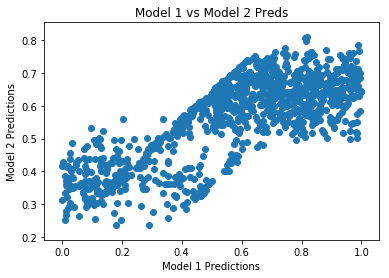

In [6]:
pred2 = gen_preds(actual_pred, pred1,viz=False).detach().numpy()
print('pred2 accuracy is ', calc_acc(pred2, actual_pred))
print('Correlation is', np.corrcoef(
    pred1, pred2)[0, 1])

plt.scatter(pred1, pred2)
plt.title('Model 1 vs Model 2 Preds')
plt.xlabel('Model 1 Predictions')
plt.ylabel('Model 2 Predictions')
plt.show()

In [7]:
# lets generate three model predictions which are correlated to each other.
# then we can test different ensembling techniques

pred3 = gen_preds(actual_pred, pred2,viz=False).detach().numpy()
print('pred3 accuracy is ', calc_acc(pred3, actual_pred))
print('Correlation is', np.corrcoef(
    pred2, pred3)[0, 1])

Model reached max accuracy.. stopping early
pred3 accuracy is  0.863
Correlation is 0.531046250343286


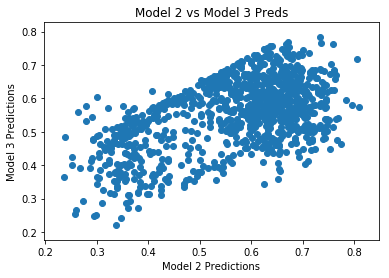

In [8]:
plt.scatter(pred2, pred3)
plt.title('Model 2 vs Model 3 Preds')
plt.xlabel('Model 2 Predictions')
plt.ylabel('Model 3 Predictions')
plt.show()

# construct a data frame with our predictions
df = pd.DataFrame()
df['pred1'] = pred1
df['pred2'] = pred2
df['pred3'] = pred3

In [9]:
# let us try taking the mean 
print('*'*50)
print('model1 accuracy:',calc_acc(pred1,actual_pred))
print('model2 accuracy:',calc_acc(pred2,actual_pred))
print('model3 accuracy:',calc_acc(pred3,actual_pred))

print('Mean accuracy:',calc_acc(df.mean(axis=1),actual_pred))
print('Median accuacy:',calc_acc(df.median(axis=1),actual_pred))

gm_pred = np.power(np.multiply(pred1,pred2,pred3), 1/3)
print('GM mean accuracy:',calc_acc(gm_pred,actual_pred))

**************************************************
model1 accuracy: 0.785
model2 accuracy: 0.856
model3 accuracy: 0.863
Mean accuracy: 0.845
Median accuacy: 0.852
GM mean accuracy: 0.814


Model reached max accuracy.. stopping early
Model reached max accuracy.. stopping early
Model reached max accuracy.. stopping early
Model reached max accuracy.. stopping early
Model reached max accuracy.. stopping early
Model reached max accuracy.. stopping early
Model reached max accuracy.. stopping early
Model reached max accuracy.. stopping early
Model reached max accuracy.. stopping early
Model reached max accuracy.. stopping early
Model reached max accuracy.. stopping early
Model reached max accuracy.. stopping early
Model reached max accuracy.. stopping early
Model reached max accuracy.. stopping early
Model reached max accuracy.. stopping early
Model reached max accuracy.. stopping early
Model reached max accuracy.. stopping early
Model reached max accuracy.. stopping early
Model reached max correlation.. stopping early
Model reached max correlation.. stopping early


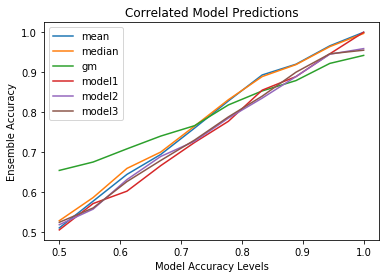

In [10]:
# now let us calculate the mean for all our models
# for different model accuracy levels
# since it has 2 classes, a random model will have an accuracy of 0.5
max_acc_levels = np.linspace(0.5,1,10)
nsamples = 1000


mode1_acc,mode2_acc,mode3_acc,model_mean,model_median,model_gm = [],[],[],[],[],[]

for acc in max_acc_levels:
    pred1,pred1_pseudo = generate_pred(1000, acc),generate_pred(1000, acc)
    pred2 = gen_preds(actual_pred, pred1,viz=False,max_model_acc=acc).detach().numpy()
    pred3 = gen_preds(actual_pred, pred1_pseudo,viz=False,max_model_acc=acc).detach().numpy()

    mode1_acc.append(calc_acc(pred1,actual_pred))
    mode2_acc.append(calc_acc(pred2,actual_pred))
    mode3_acc.append(calc_acc(pred3,actual_pred))

    model_mean.append(calc_acc(np.mean([pred1,pred2,pred3],axis=0),actual_pred))

    model_median.append(calc_acc(np.median([pred1,pred2,pred3],axis=0),actual_pred))

    gm_pred = np.power(np.multiply(pred1,pred2,pred3), 1/3)

    model_gm.append(calc_acc(gm_pred,actual_pred))

# print(len(model_mean))
plt.plot(max_acc_levels,model_mean)
plt.plot(max_acc_levels,model_median)
plt.plot(max_acc_levels,model_gm)
plt.plot(max_acc_levels,mode1_acc)
plt.plot(max_acc_levels,mode2_acc)
plt.plot(max_acc_levels,mode3_acc)
plt.legend(['mean','median','gm','model1','model2','model3'])
plt.xlabel('Model Accuracy Levels')
plt.ylabel('Ensemble Accuracy')
plt.title('Correlated Model Predictions')
plt.show()


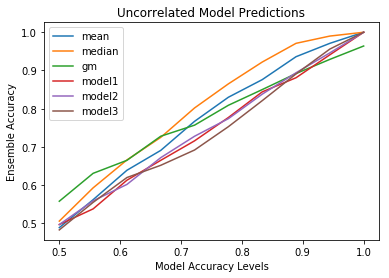

In [11]:
# Let us generate three predictions using generate_pred function.
# These functions wont be correlated with each other. So, this is not a practical scenario.
# In practical scenarios, we are usually using the same data to train different algorithms.\
# So, the model predictions will be correlated to each other.
# Let us see which ensembling strategy works best in this case.
mode1_acc,mode2_acc,mode3_acc,model_mean,model_median,model_gm = [],[],[],[],[],[]

for acc in max_acc_levels:
    pred1,pred2,pred3 = generate_pred(1000, acc),generate_pred(1000, acc),generate_pred(1000, acc)

    mode1_acc.append(calc_acc(pred1,actual_pred))
    mode2_acc.append(calc_acc(pred2,actual_pred))
    mode3_acc.append(calc_acc(pred3,actual_pred))

    model_mean.append(calc_acc(np.mean([pred1,pred2,pred3],axis=0),actual_pred))

    model_median.append(calc_acc(np.median([pred1,pred2,pred3],axis=0),actual_pred))

    gm_pred = np.power(np.multiply(pred1,pred2,pred3), 1/3)

    model_gm.append(calc_acc(gm_pred,actual_pred))

plt.plot(max_acc_levels,model_mean)
plt.plot(max_acc_levels,model_median)
plt.plot(max_acc_levels,model_gm)
plt.plot(max_acc_levels,mode1_acc)
plt.plot(max_acc_levels,mode2_acc)
plt.plot(max_acc_levels,mode3_acc)
plt.legend(['mean','median','gm','model1','model2','model3'])
plt.xlabel('Model Accuracy Levels')
plt.ylabel('Ensemble Accuracy')
plt.title('Uncorrelated Model Predictions')
plt.show()